<a href="https://colab.research.google.com/github/abhx7/Deep-Learning-with-PyTorch---GANS/blob/main/02_insurance_linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Insurance cost prediction using linear regression

Make a submisson here: https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans/assignment/assignment-2-train-your-first-model

In this assignment we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from [Kaggle](https://www.kaggle.com/mirichoi0218/insurance).


We will create a model with the following steps:
1. Download and explore the dataset
2. Prepare the dataset for training
3. Create a linear regression model
4. Train the model to fit the data
5. Make predictions using the trained model


This assignment builds upon the concepts from the first 2 lessons. It will help to review these Jupyter notebooks:
- PyTorch basics: https://jovian.ai/aakashns/01-pytorch-basics
- Linear Regression: https://jovian.ai/aakashns/02-linear-regression
- Logistic Regression: https://jovian.ai/aakashns/03-logistic-regression
- Linear regression (minimal): https://jovian.ai/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ai/aakashns/mnist-logistic-minimal

As you go through this notebook, you will find a **???** in certain places. Your job is to replace the **???** with appropriate code or values, to ensure that the notebook runs properly end-to-end . In some cases, you'll be required to choose some hyperparameters (learning rate, batch size etc.). Try to experiment with the hypeparameters to get the lowest loss.


In [469]:
# Uncomment and run the appropriate command for your operating system, if required

# Linux / Binder
# !pip install numpy matplotlib pandas torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Windows
# !pip install numpy matplotlib pandas torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# MacOS
# !pip install numpy matplotlib pandas torch torchvision torchaudio

In [470]:
# Uncomment and run the commands below if imports fail
# !conda install numpy pytorch torchvision cpuonly -c pytorch -y
# !pip install matplotlib --upgrade --quiet
!pip install jovian --upgrade --quiet

In [471]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [472]:
project_name='02-insurance-linear-regression-abhi' # will be used by jovian.commit

## Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file.

In [473]:
DATASET_URL = "https://gist.github.com/BirajCoder/5f068dfe759c1ea6bdfce9535acdb72d/raw/c84d84e3c80f93be67f6c069cbdc0195ec36acbd/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

Using downloaded and verified file: ./insurance.csv


To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

In [474]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to do a slight customization of the data, so that you every participant receives a slightly different version of the dataset. Fill in your name below as a string (enter at least 5 characters)

In [475]:
your_name = 'abhigyan' # at least 5 characters

The `customize_dataset` function will customize the dataset slightly using your name as a source of random numbers.

In [476]:
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [477]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()

,age,sex,bmi,children,smoker,charges
27,55,female,32.1195,2,no,12759.377540
997,63,female,36.1130,0,no,14443.487240
162,54,male,38.8080,1,no,10868.574080
824,60,male,23.8336,0,no,13024.548992
392,48,male,30.8161,1,no,9322.622972


Let us answer some basic questions about the dataset.


**Q1: How many rows does the dataset have?**

In [478]:
num_rows = len(dataframe)
print(num_rows)

1271


**Q2: How many columns doe the dataset have**

In [479]:
num_cols = len(dataframe.axes[1])
print(num_cols)

6


**Q3: What are the column titles of the input variables?**

In [480]:
input_cols = dataframe.axes[1]
input_cols

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'charges'], dtype='object')

**Q4: Which of the input columns are non-numeric or categorial variables ?**

Hint: `sex` is one of them. List the columns that are not numbers.

In [481]:
#how code
categorical_cols = ['sex','smoker']

**Q5: What are the column titles of output/target variable(s)?**

In [482]:
output_cols = ['charges']

**Q: (Optional) What is the minimum, maximum and average value of the `charges` column? Can you show the distribution of values in a graph?**
Use this data visualization cheatsheet for referece: https://jovian.ai/aakashns/dataviz-cheatsheet

Minimum charges:  1166.7488560000002
Maximum charges:  66321.2451304


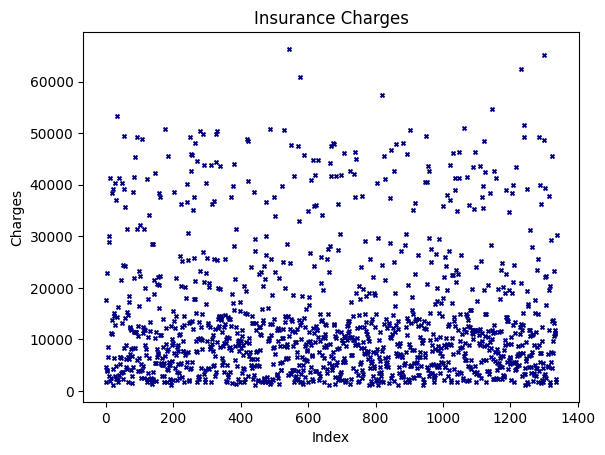

In [483]:
# Write your answer here
import matplotlib.pyplot as plt

min_charge=dataframe.charges.min()
max_charge=dataframe.charges.max()

# First line
plt.plot(dataframe.axes[0], dataframe.charges, 'x', linewidth=1, markersize=1, markeredgewidth=4, markeredgecolor='navy')
plt.title('Insurance Charges') # Title
plt.xlabel('Index'); plt.ylabel('Charges'); # Axis labels

print("Minimum charges: ",min_charge)
print("Maximum charges: ",max_charge)

Average charges:  13846.76311797243


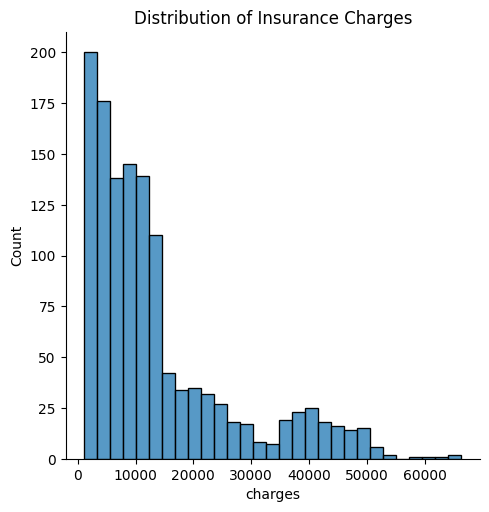

In [484]:
import seaborn as sns
sns.displot(dataframe.charges);
plt.title("Distribution of Insurance Charges")

avg_charge=dataframe.charges.mean()
print("Average charges: ",avg_charge)

Remember to commit your notebook to Jovian after every step, so that you don't lose your work.

In [485]:
!pip install jovian --upgrade -q

In [486]:
import jovian

In [487]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [488]:
dataframe.values

array([[55, 'female', 32.119499999999995, 2, 'no', 12759.37754],
       [63, 'female', 36.113, 0, 'no', 14443.487240000002],
       [54, 'male', 38.808, 1, 'no', 10868.57408],
       ...,
       [58, 'male', 31.3698, 1, 'no', 12424.490935999998],
       [32, 'female', 43.33559999999999, 0, 'no', 4153.944912],
       [35, 'male', 17.5028, 1, 'no', 5321.160416]], dtype=object)

In [489]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

Read through the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) to understand how we're converting categorical variables into numbers.

In [490]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[5.50000000e+01, 0.00000000e+00, 3.21195000e+01, 2.00000000e+00,
         0.00000000e+00, 1.27593775e+04],
        [6.30000000e+01, 0.00000000e+00, 3.61130000e+01, 0.00000000e+00,
         0.00000000e+00, 1.44434872e+04],
        [5.40000000e+01, 1.00000000e+00, 3.88080000e+01, 1.00000000e+00,
         0.00000000e+00, 1.08685741e+04],
        ...,
        [5.80000000e+01, 1.00000000e+00, 3.13698000e+01, 1.00000000e+00,
         0.00000000e+00, 1.24244909e+04],
        [3.20000000e+01, 0.00000000e+00, 4.33356000e+01, 0.00000000e+00,
         0.00000000e+00, 4.15394491e+03],
        [3.50000000e+01, 1.00000000e+00, 1.75028000e+01, 1.00000000e+00,
         0.00000000e+00, 5.32116042e+03]]),
 array([[12759.37754 ],
        [14443.48724 ],
        [10868.57408 ],
        ...,
        [12424.490936],
        [ 4153.944912],
        [ 5321.160416]]))

**Q6: Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. Make sure that the data type is `torch.float32`.**

In [491]:
inputs = torch.tensor(inputs_array,dtype=torch.float32)
targets = torch.tensor(targets_array,dtype=torch.float32)

In [492]:
inputs

tensor([[5.5000e+01, 0.0000e+00, 3.2119e+01, 2.0000e+00, 0.0000e+00, 1.2759e+04],
        [6.3000e+01, 0.0000e+00, 3.6113e+01, 0.0000e+00, 0.0000e+00, 1.4443e+04],
        [5.4000e+01, 1.0000e+00, 3.8808e+01, 1.0000e+00, 0.0000e+00, 1.0869e+04],
        ...,
        [5.8000e+01, 1.0000e+00, 3.1370e+01, 1.0000e+00, 0.0000e+00, 1.2424e+04],
        [3.2000e+01, 0.0000e+00, 4.3336e+01, 0.0000e+00, 0.0000e+00, 4.1539e+03],
        [3.5000e+01, 1.0000e+00, 1.7503e+01, 1.0000e+00, 0.0000e+00, 5.3212e+03]])

In [493]:
targets

tensor([[12759.3779],
        [14443.4873],
        [10868.5742],
        ...,
        [12424.4912],
        [ 4153.9448],
        [ 5321.1606]])

In [494]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [495]:
dataset = TensorDataset(inputs, targets)

**Q7: Pick a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then use `random_split` to create training & validation datasets.**

In [496]:
val_percent = 0.15 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size

train_ds, val_ds = random_split(dataset,[train_size,val_size]) # Use the random_split function to split dataset into 2 parts of the desired length

Finally, we can create data loaders for training & validation.

**Q8: Pick a batch size for the data loader.**

In [497]:
batch_size = 32

In [498]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [499]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[4.9000e+01, 1.0000e+00, 2.8116e+01, 3.0000e+00, 0.0000e+00, 1.0675e+04],
        [2.1000e+01, 1.0000e+00, 2.5509e+01, 0.0000e+00, 0.0000e+00, 2.1864e+03],
        [3.6000e+01, 0.0000e+00, 2.2148e+01, 2.0000e+00, 1.0000e+00, 1.9353e+04],
        [4.5000e+01, 0.0000e+00, 3.0282e+01, 2.0000e+00, 0.0000e+00, 8.8608e+03],
        [5.8000e+01, 0.0000e+00, 3.2771e+01, 0.0000e+00, 0.0000e+00, 1.2721e+04],
        [6.3000e+01, 1.0000e+00, 3.6030e+01, 0.0000e+00, 0.0000e+00, 1.4541e+04],
        [6.2000e+01, 1.0000e+00, 3.0831e+01, 1.0000e+00, 0.0000e+00, 2.8081e+04],
        [1.9000e+01, 1.0000e+00, 1.9404e+01, 0.0000e+00, 0.0000e+00, 1.2912e+03],
        [5.7000e+01, 0.0000e+00, 3.0537e+01, 0.0000e+00, 1.0000e+00, 4.5322e+04],
        [4.7000e+01, 0.0000e+00, 2.6068e+01, 2.0000e+00, 0.0000e+00, 1.0104e+04],
        [5.4000e+01, 1.0000e+00, 3.2957e+01, 1.0000e+00, 0.0000e+00, 1.1258e+04],
        [2.5000e+01, 0.0000e+00, 2.6254e+01, 2.0000e+00, 0.0000e+00, 4.3567e+03],
        

Let's save our work by committing to Jovian.

In [500]:
jovian.commit(project='02-insurance-linear-abhi', environment=None)

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment).


In [501]:
input_size = len(input_cols)
output_size = len(output_cols)

**Q9: Complete the class definition below by filling out the constructor (`__init__`), `forward`, `training_step` and `validation_step` methods.**

Hint: Think carefully about picking a good loss fuction (it's not cross entropy). Maybe try 2-3 of them and see which one works best. See https://pytorch.org/docs/stable/nn.functional.html#loss-functions

In [502]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size,output_size)

    def forward(self, xb):
        out = self.linear(xb)
        return out

    def training_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calcuate loss
        loss = F.mse_loss(out, targets)
        return loss

    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.mse_loss(out, targets)
        return {'val_loss': loss.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 10th epoch
        if (epoch+1) % 10 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [503]:
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [504]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0813, -0.3695,  0.2510,  0.2660, -0.1360, -0.1480]],
        requires_grad=True),
 Parameter containing:
 tensor([0.0727], requires_grad=True)]

One final commit before we train the model.

In [505]:
jovian.commit(project='02-insurance-linear-abhi', environment=None)

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [506]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Q10: Use the `evaluate` function to calculate the loss on the validation set before training.**

In [507]:
result = evaluate(model,train_loader) # Use the the evaluate function
print(result)

{'val_loss': 441062048.0}



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**Q11: Train the model 4-5 times with different learning rates & for different number of epochs.**

Hint: Vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [508]:
epochs = 100
lr = 1e-12
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [10], val_loss: 365995296.0000
Epoch [20], val_loss: 231510064.0000
Epoch [30], val_loss: 146577040.0000
Epoch [40], val_loss: 92771840.0000
Epoch [50], val_loss: 58739700.0000
Epoch [60], val_loss: 37181748.0000
Epoch [70], val_loss: 23528050.0000
Epoch [80], val_loss: 14894753.0000
Epoch [90], val_loss: 9428246.0000
Epoch [100], val_loss: 5966964.0000


In [509]:
epochs = 100
lr = 1e-12
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [10], val_loss: 3777658.7500
Epoch [20], val_loss: 2391056.5000
Epoch [30], val_loss: 1513800.6250
Epoch [40], val_loss: 958439.3125
Epoch [50], val_loss: 607021.2500
Epoch [60], val_loss: 384519.2188
Epoch [70], val_loss: 243538.8594
Epoch [80], val_loss: 154275.4531
Epoch [90], val_loss: 97757.8828
Epoch [100], val_loss: 61976.6445


In [510]:
epochs = 100
lr = 1e-12
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [10], val_loss: 39333.1016
Epoch [20], val_loss: 24974.7969
Epoch [30], val_loss: 15873.5352
Epoch [40], val_loss: 10106.3369
Epoch [50], val_loss: 6446.1675
Epoch [60], val_loss: 4126.1069
Epoch [70], val_loss: 2653.5664
Epoch [80], val_loss: 1714.0836
Epoch [90], val_loss: 1117.5634
Epoch [100], val_loss: 736.8560


In [511]:
epochs = 100
lr = 1e-12
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [10], val_loss: 493.8036
Epoch [20], val_loss: 338.1849
Epoch [30], val_loss: 238.1437
Epoch [40], val_loss: 173.9768
Epoch [50], val_loss: 132.5552
Epoch [60], val_loss: 105.4735
Epoch [70], val_loss: 87.6732
Epoch [80], val_loss: 76.0515
Epoch [90], val_loss: 68.2220
Epoch [100], val_loss: 63.0591


In [512]:
epochs = 100
lr = 1e-12
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [10], val_loss: 59.5200
Epoch [20], val_loss: 57.2221
Epoch [30], val_loss: 55.5903
Epoch [40], val_loss: 54.4790
Epoch [50], val_loss: 53.6952
Epoch [60], val_loss: 53.0776
Epoch [70], val_loss: 52.6596
Epoch [80], val_loss: 52.3317
Epoch [90], val_loss: 52.1010
Epoch [100], val_loss: 51.9161


**Q12: What is the final validation loss of your model?**

In [513]:
val_loss = evaluate(model,train_loader)['val_loss']
val_loss

52.944297790527344

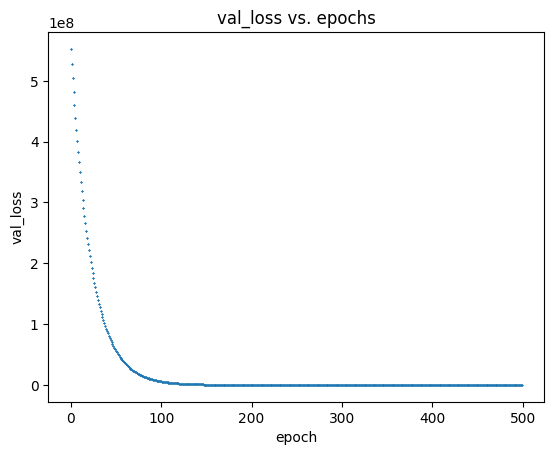

In [514]:
losses = [x['val_loss'] for x in history1+history2+history3+history4+history5]
plt.plot(losses, 'x', linewidth=1, markersize=1,)
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.title('val_loss vs. epochs');

In [516]:
print("Average charges: ",avg_charge)

Average charges:  13846.76311797243


In [517]:
print("Average losses:")
numpy.average(numpy.sqrt(losses))

Average losses:


2081.2693592908645

This is an acceptable average loss for the average insurance charge.

Let's log the final validation loss to Jovian and commit the notebook

In [518]:
jovian.log_metrics(val_loss=val_loss)

[jovian] Metrics logged.


In [519]:
jovian.commit(project='02-insurance-linear-abhi', environment=None)

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


Now scroll back up, re-initialize the model, and try different set of values for batch size, number of epochs, learning rate etc. Commit each experiment and use the "Compare" and "View Diff" options on Jovian to compare the different results.

## Step 5: Make predictions using the trained model

**Q13: Complete the following function definition to make predictions on a single input**

In [520]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target.item())
    print("Prediction:", prediction.item())

In [521]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([5.4000e+01, 1.0000e+00, 3.0968e+01, 0.0000e+00, 0.0000e+00, 1.0244e+04])
Target: 10244.44921875
Prediction: 10251.57421875


In [522]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([6.2000e+01, 0.0000e+00, 2.9885e+01, 2.0000e+00, 0.0000e+00, 1.5621e+04])
Target: 15620.55078125
Prediction: 15626.40234375


In [523]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([5.3000e+01, 1.0000e+00, 2.9885e+01, 0.0000e+00, 0.0000e+00, 1.0475e+04])
Target: 10474.9375
Prediction: 10481.5947265625


Are you happy with your model's predictions? Try to improve them further.

## (Optional) Step 6: Try another dataset & blog about it

While this last step is optional for the submission of your assignment, we highly recommend that you do it. Try to replicate this notebook for a different linear regression or logistic regression problem. This will help solidify your understanding, and give you a chance to differentiate the generic patterns in machine learning from problem-specific details.You can use one of these starer notebooks (just change the dataset):

- Linear regression (minimal): https://jovian.ai/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ai/aakashns/mnist-logistic-minimal

Here are some sources to find good datasets:

- https://lionbridge.ai/datasets/10-open-datasets-for-linear-regression/
- https://www.kaggle.com/rtatman/datasets-for-regression-analysis
- https://archive.ics.uci.edu/ml/datasets.php?format=&task=reg&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table
- https://people.sc.fsu.edu/~jburkardt/datasets/regression/regression.html
- https://archive.ics.uci.edu/ml/datasets/wine+quality
- https://pytorch.org/docs/stable/torchvision/datasets.html

We also recommend that you write a blog about your approach to the problem. Here is a suggested structure for your post (feel free to experiment with it):

- Interesting title & subtitle
- Overview of what the blog covers (which dataset, linear regression or logistic regression, intro to PyTorch)
- Downloading & exploring the data
- Preparing the data for training
- Creating a model using PyTorch
- Training the model to fit the data
- Your thoughts on how to experiment with different hyperparmeters to reduce loss
- Making predictions using the model

As with the previous assignment, you can [embed Juptyer notebook cells & outputs from Jovian](https://medium.com/jovianml/share-and-embed-jupyter-notebooks-online-with-jovian-ml-df709a03064e) into your blog.

Don't forget to share your work on the forum: https://jovian.ai/forum/t/linear-regression-and-logistic-regression-notebooks-and-blog-posts/14039

In [524]:
jovian.commit(project='02-insurance-linear-abhi', environment=None)
jovian.commit(project='02-insurance-linear-abhi', environment=None) # try again, kaggle fails sometimes

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.
[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.
